In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8)

# Get and prepare data

In [3]:
curve1 = pd.read_csv('curve1.csv')
curve2 = pd.read_csv('curve2.csv')

In [4]:
time = pd.read_csv('time.csv')

In [5]:
data = pd.concat([curve1, curve2])

In [6]:
data.shape

(1667, 2)

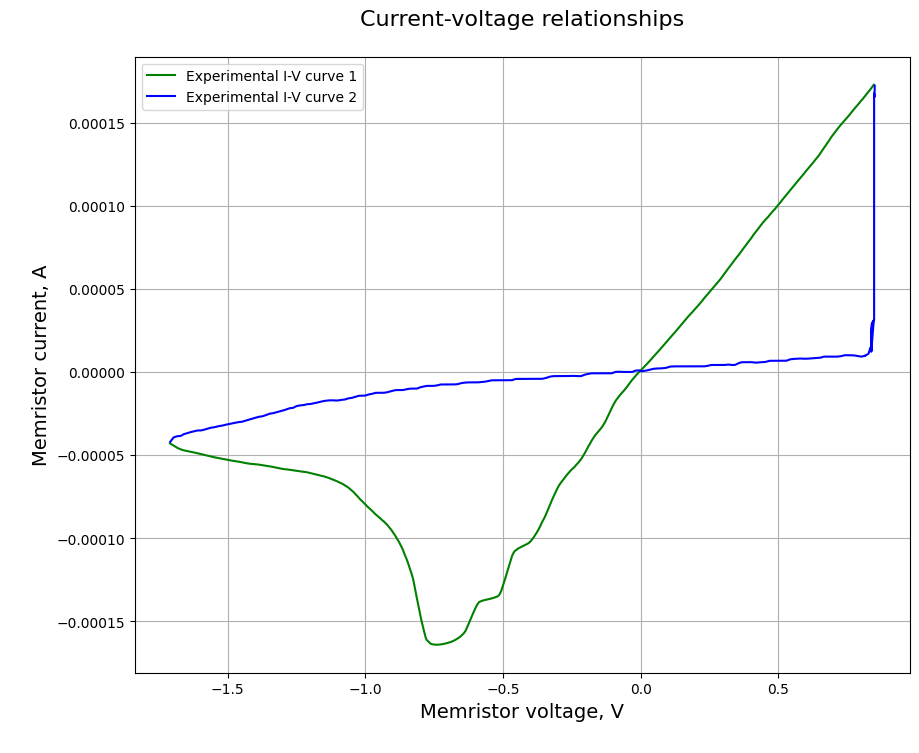

In [7]:
plt.plot(curve1['V'], curve1['A'], 'g', label='Experimental I-V curve 1')
plt.plot(curve2['V'], curve2['A'], 'b', label='Experimental I-V curve 2')
plt.title('Current-voltage relationships\n', fontsize=16)
plt.xlabel('Memristor voltage, V\n', fontsize=14)
plt.ylabel('\nMemristor current, A', fontsize=14)
plt.legend()
plt.grid()
plt.show()

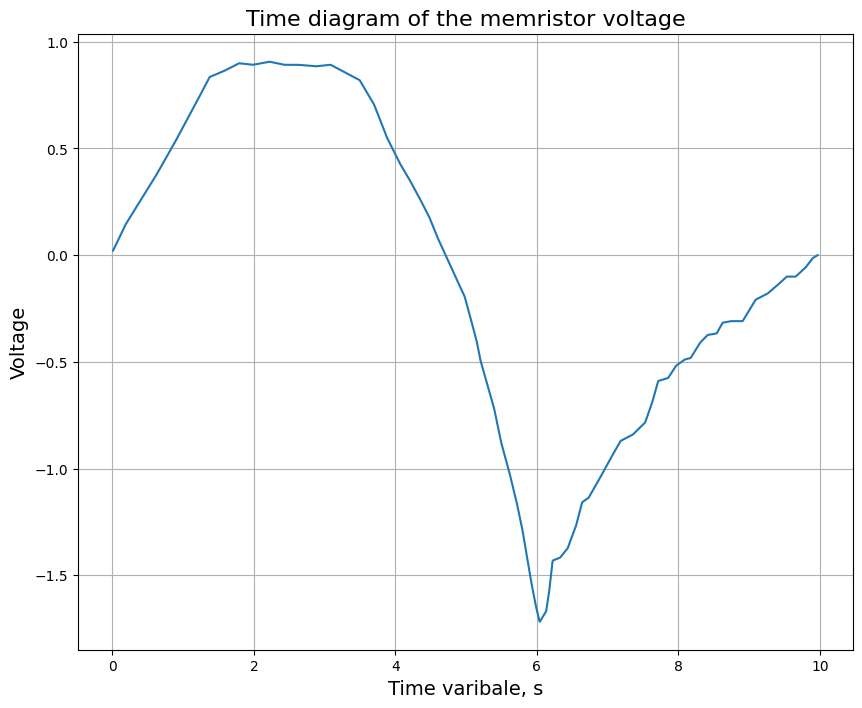

In [8]:
plt.plot(time['t'], time['v'])
plt.title('Time diagram of the memristor voltage', fontsize=16)
plt.ylabel('Voltage', fontsize=14)
plt.xlabel('Time varibale, s', fontsize=14)
plt.grid()
plt.show()

In [149]:
def main_model(x, n, alph, betha, v, X, Y):
    betha = betha / 1000000
    X = X / 1000000
    return (x ** n) * betha * np.sinh(alph * v) + X * (np.exp(Y * v) - 1)

In [150]:
P = 5
J = 1 / 2

In [151]:
time

,t,v
0,0.010601,0.021583
1,0.016578,0.025720
2,0.022555,0.029858
3,0.028532,0.033995
4,0.034509,0.038132
...,...,...
1662,9.944290,-0.004868
1663,9.950267,-0.003651
1664,9.956244,-0.002434
1665,9.962221,-0.001217


In [152]:
t = time['t'].values
v = time['v'].values
h = []
for i in range(1, len(t)):
    h.append(t[i] - t[i - 1])

# Biolek

In [178]:
def biolek(x, v):
    if v <= 0.0:
        return 1 - (x - 1) ** (2 * P)
    if v > 0.0:
        return 1 - x ** (2 * P)

# Modified Biolek

In [179]:
def biolek_mod(x, v, b, c, v_thresh):
    p = round(b / (abs(v) + c))
    if v <= (-1) * v_thresh:
        return 1 - (x - 1) ** (2 * p)
    if v > v_thresh:
        return 1 - x ** (2 * p)
    if (-1) * v_thresh < v <= v_thresh:
        return 0

# Joglekar

In [180]:
def joglekar(x):
    return 1 - (2 * x - 1) ** (2 * J)

# Modified Joglekar

In [181]:
def joglekar_mod(x):
    jg = 1 - (2 * x - 1) ** (2 * J)
    return (4.5 * jg + 5.5 * np.sin(np.pi * x) * np.sin(np.pi * x)) / 10

# Function

In [182]:
def current_voltage_func(v, h, flag, x_0=0.4, v_thresh=0.8, s=5, alph=1.8, a=1, betha=90, b=15, c=2, n=5, X=150, Y=0.15):
    x_vals = np.zeros(len(h) + 1)
    x_vals[0] = x_0
    I_vals = np.zeros(len(h) + 1)
    I_vals[0] = main_model(x_0, int(n), alph, betha, v[0], int(X), Y)
    for i in range(1, len(h)):
        if flag == 'biolek_mod':
            x_vals[i] = x_vals[i-1] + ((a * biolek_mod(x_vals[i-1], v[i], b, c, v_thresh) * (v[i] ** int(s))) * h[i])
        elif flag == 'biolek':
            x_vals[i] = x_vals[i-1] + ((a * biolek(x_vals[i-1], v[i]) * (v[i] ** int(s))) * h[i])
        elif flag == 'joglekar':
            x_vals[i] = x_vals[i-1] + ((a * joglekar(x_vals[i-1]) * (v[i] ** int(s))) * h[i])
        elif flag == 'joglekar_mod':
            x_vals[i] = x_vals[i-1] + ((a * joglekar_mod(x_vals[i-1]) * (v[i] ** int(s))) * h[i])
        if x_vals[i] < 0:
            x_vals[i] = 0
        if x_vals[i] > 1:
            x_vals[i] = 1
        I_vals[i] = main_model(x_vals[i], int(n), alph, int(betha), v[i], int(X), Y)
    return I_vals

In [183]:
v

array([ 0.02158273,  0.02572016,  0.02985758, ..., -0.00243378,
       -0.00121689,  0.        ])

# Prepare functions

In [184]:
I_Biolek = current_voltage_func(v=v, h=h, flag='biolek')
I_Biolek_Mod = current_voltage_func(v=v, h=h, flag='biolek_mod')
I_Joglekar = current_voltage_func(v=v, h=h, flag='joglekar')
I_Joglekar_Mod = current_voltage_func(v=v, h=h, flag='joglekar_mod')

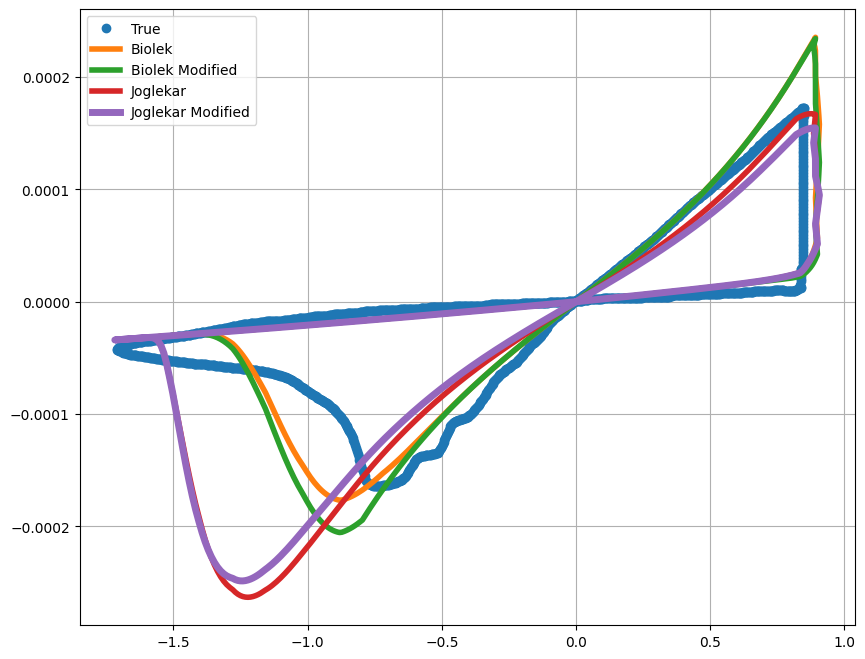

In [199]:
plt.plot(data['V'], data['A'], 'o')
plt.plot(v, I_Biolek, linewidth=4.0)
plt.plot(v, I_Biolek_Mod, linewidth=4.0)
plt.plot(v, I_Joglekar, linewidth=4.0)
plt.plot(v, I_Joglekar_Mod, linewidth=5.0)
plt.grid()
plt.legend(['True', 'Biolek', 'Biolek Modified', 'Joglekar', 'Joglekar Modified'])

# Combined

In [166]:
comb = np.zeros(v.shape[0])
for i in range(v.shape[0]):
    if v[i] > 0:
        comb[i] = I_Joglekar[i]
    else:
        comb[i] = I_Biolek[i]

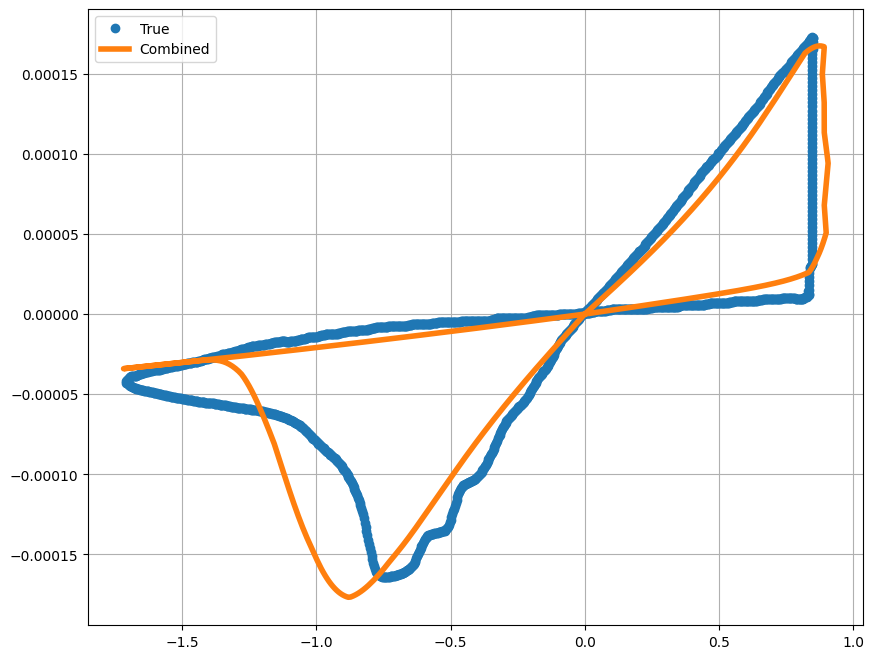

In [200]:
plt.plot(data['V'], data['A'], 'o')
plt.plot(v, comb, linewidth=4.0)
plt.grid()
plt.legend(['True', 'Combined'])

# ML

## KNN

In [188]:
from sklearn.neighbors import KNeighborsRegressor

knn1 = KNeighborsRegressor()
knn2 = KNeighborsRegressor()

curve1 = pd.read_csv('curve1.csv')
y1 = curve1['A']
x1 = curve1.drop('V', axis=1)
knn1.fit(x1, y1)
pred1 = knn1.predict(x1)


curve2 = pd.read_csv('curve2.csv')
y2 = curve2['A']
x2 = curve2.drop('V', axis=1)
knn2.fit(x2, y2)
pred2 = knn2.predict(x2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


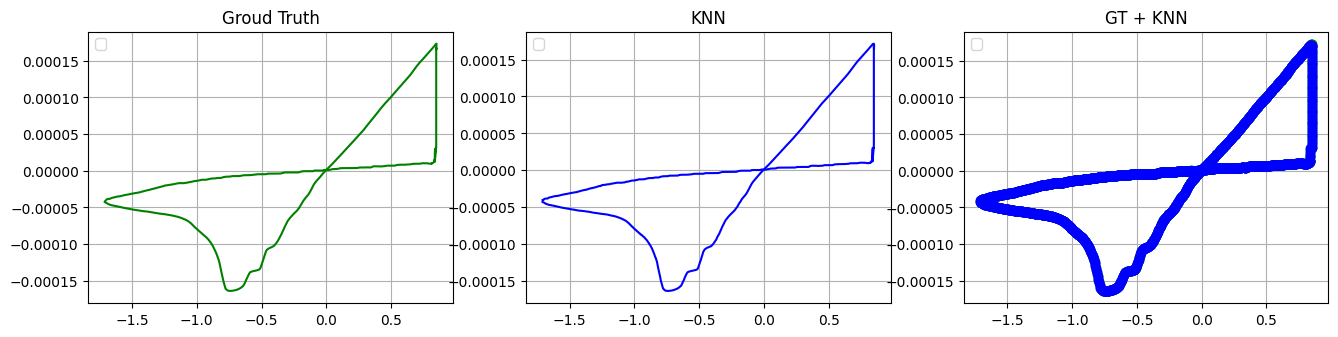

In [191]:
fig = plt.figure(figsize=(16, 12))

plt.subplot(3, 3, 1)
plt.title("Groud Truth")
plt.plot(curve1['V'], curve1['A'], 'g');
plt.plot(curve2['V'], curve2['A'], 'g');
plt.legend()
plt.grid()

plt.subplot(3, 3, 2)
plt.title("KNN")
plt.plot(curve1['V'], pred1, 'b');
plt.plot(curve2['V'], pred2, 'b');
plt.legend()
plt.grid()

plt.subplot(3, 3, 3)
plt.title("GT + KNN")
plt.plot(curve1['V'], curve1['A'], 'go', linewidth = 0.1);
plt.plot(curve2['V'], curve2['A'], 'go', linewidth = 0.1);
plt.plot(curve1['V'], pred1, 'bo', linewidth = 0.1);
plt.plot(curve2['V'], pred2, 'bo', linewidth = 0.1);
plt.legend()
plt.grid()


## GBR

In [192]:
from sklearn.ensemble import GradientBoostingRegressor

gbr1 = GradientBoostingRegressor()
gbr2 = GradientBoostingRegressor()

gbr1.fit(x1, y1)
pred1 = gbr1.predict(x1)

gbr2.fit(x2, y2)
pred2 = gbr2.predict(x2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


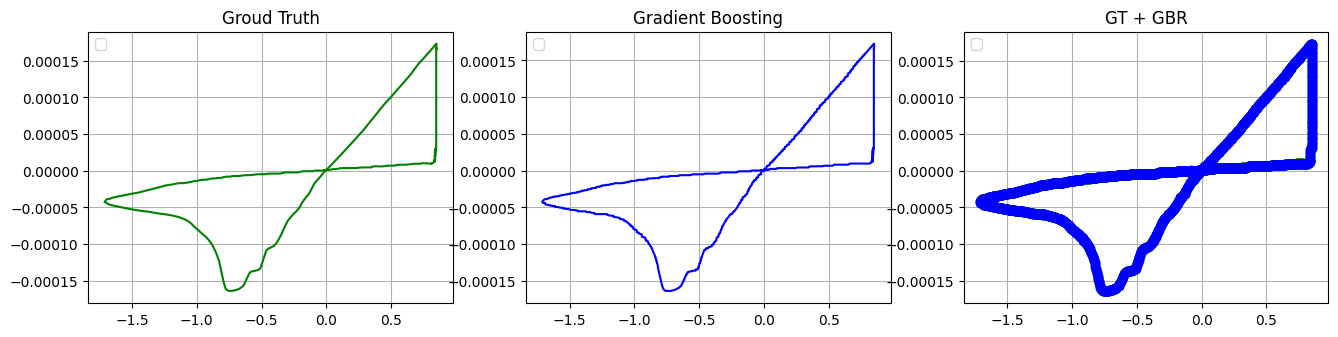

In [193]:
fig = plt.figure(figsize=(16, 12))

plt.subplot(3, 3, 1)
plt.title("Groud Truth")
plt.plot(curve1['V'], curve1['A'], 'g');
plt.plot(curve2['V'], curve2['A'], 'g');
plt.legend()
plt.grid()

plt.subplot(3, 3, 2)
plt.title("Gradient Boosting")
plt.plot(curve1['V'], pred1, 'b');
plt.plot(curve2['V'], pred2, 'b');
plt.legend()
plt.grid()

plt.subplot(3, 3, 3)
plt.title("GT + GBR")
plt.plot(curve1['V'], curve1['A'], 'go', linewidth = 0.1);
plt.plot(curve2['V'], curve2['A'], 'go', linewidth = 0.1);
plt.plot(curve1['V'], pred1, 'bo', linewidth = 0.1);
plt.plot(curve2['V'], pred2, 'bo', linewidth = 0.1);
plt.legend()
plt.grid()

In [194]:
from sklearn.ensemble import RandomForestRegressor

rfr1 = RandomForestRegressor()
rfr2 = RandomForestRegressor()

rfr1.fit(x1, y1)
pred1 = rfr1.predict(x1)

rfr1.fit(x2, y2)
pred2 = rfr1.predict(x2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


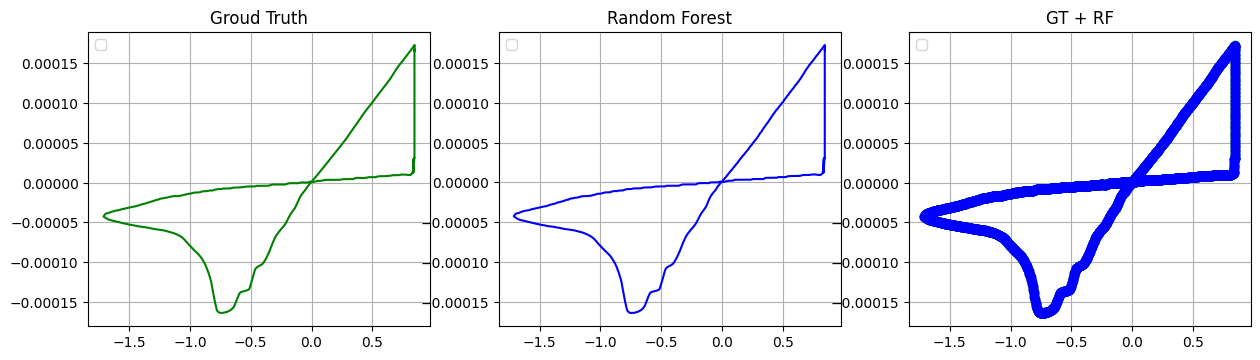

In [195]:
_min, _max = 0, 6
fig = plt.figure(figsize=(15, 13))
fname = ''

plt.subplot(3, 3, 1)
plt.title("Groud Truth")
plt.plot(curve1['V'], curve1['A'], 'g');
plt.plot(curve2['V'], curve2['A'], 'g');
plt.legend()
plt.grid()

plt.subplot(3, 3, 2)
plt.title("Random Forest")
plt.plot(curve1['V'], pred1, 'b');
plt.plot(curve2['V'], pred2, 'b');
plt.legend()
plt.grid()

plt.subplot(3, 3, 3)
plt.title("GT + RF")
plt.plot(curve1['V'], curve1['A'], 'go', linewidth = 0.1);
plt.plot(curve2['V'], curve2['A'], 'go', linewidth = 0.1);
plt.plot(curve1['V'], pred1, 'bo', linewidth = 0.1);
plt.plot(curve2['V'], pred2, 'bo', linewidth = 0.1);
plt.legend()
plt.grid()
